In [1]:
import os
import sys
projectDir = '/mnt/c/Users/Julien Fournier/Documents/GitHub/RakutenTeam'
sys.path.append(projectDir)

#Define path in the config file
import src.config as config
config.path_to_project = projectDir #directory of the project
config.path_to_data = os.path.join(projectDir, 'data', 'clean') #path to the data (dataframe)
config.path_to_results = os.path.join('/mnt/c/Users/Julien Fournier/Documents/DST/RakutenProject', 'results') #path to where the summary of the benchmark results will be saved (csv)
config.path_to_images = '/home/jul/DST/Rakuten/Data/images/image_train_resized' #path to the folder containing images
config.path_to_models = '/mnt/c/Users/Julien Fournier/Documents/DST/RakutenProject/models' #path to the folder where the models will be saved
config.path_to_tflogs = os.path.join('/mnt/c/Users/Julien Fournier/Documents/DST/RakutenProject', 'tf_logs') #Path to where tensorboard logs will be saved

import pandas as pd
import numpy as np

import tensorflow as tf

from Rakuten_preprocessing import Rakuten_img_path

from src.text.classifiers import TFbertClassifier
from src.image.classifiers import ImgClassifier
from src.multimodal.classifiers import TFmultiClassifier

from src.utils.batch import fit_save_all
from src.utils.plot import plot_training_history

import datetime


2024-03-10 15:31:32.117300: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-10 15:31:32.159265: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-10 15:31:32.159295: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-10 15:31:32.160482: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-10 15:31:32.169175: I tensorflow/core/platform/cpu_feature_guar

In [2]:
data_train = pd.read_csv(os.path.join(config.path_to_data, 'df_train_index.csv'))
data_train['testset'] = False
data_test = pd.read_csv(os.path.join(config.path_to_data, 'df_test_index.csv'))
data_test['testset'] = True
data = pd.concat([data_train, data_test], axis=0)

#merging text into token column
colnames = ['designation_translated', 'description_translated'] #['designation', 'description']#
data['tokens'] = data[colnames].apply(lambda row: ' '.join(s.lower() for s in row if isinstance(s, str)), axis=1)

#path to images into img_path column
data['img_path'] = Rakuten_img_path(img_folder=config.path_to_images,
                             imageid=data['imageid'], productid=data['productid'], suffix='_resized')


In [3]:
#labels of encoded classes
class_labels = data.groupby('prdtypedesignation')['prdtypeindex'].first().reset_index()
class_labels.index = class_labels['prdtypeindex']
class_labels = class_labels.drop(columns='prdtypeindex').sort_index()

## Creating train and test sets

In [4]:
Img_train = data.loc[~data['testset'], 'img_path']
Img_test = data.loc[data['testset'], 'img_path']

Txt_train = data.loc[~data['testset'], 'tokens']
Txt_test = data.loc[data['testset'], 'tokens']

y_train = data.loc[~data['testset'],'prdtypeindex']
y_test = data.loc[data['testset'],'prdtypeindex']

#To be fed into any of our sklearn classifiers, X_train and X_test
#should be dataframes with columns tokens and img_path
X_train = pd.DataFrame({'tokens': Txt_train, 'img_path': Img_train})
X_test = pd.DataFrame({'tokens': Txt_test, 'img_path': Img_test})

#All data for cross-validated scores
X = pd.concat([X_train, X_test], axis=0)
y = pd.concat([y_train, y_test], axis=0)

#Number of classes
num_classes = len(np.unique(data['prdtypeindex']))

## CNN benchmarks

In [5]:
params_list = []
class_type = 'ImgClassifier'

#training parameters
num_class = 27
n_epochs = 2
batch_size = 32
lr0 = 5e-5
lr_decay_rate = 0.8

#defining callbacks
callbacks = []
def lrscheduler(epoch, lr):
  return max(1e-6, lr * lr_decay_rate)
callbacks.append(('LearningRateScheduler', {'schedule': lrscheduler}))
callbacks.append(('EarlyStopping', {'monitor': 'val_accuracy', 'min_delta': 0, 'mode': 'max', 'patience': 2, 'restore_best_weights': True, 'verbose': 1}))

#Adding tensorboard callback as the last one
callbacks.append(('TensorBoard', {'log_dir': np.nan, 'histogram_freq': 1, 'update_freq': 'epoch'}))

#grid search number of folds
nfolds_grid = 0

#cross-validation of f1-score
nfolds_cv = 0

#Adjusting tensorboard log directory
log_dir = os.path.join(config.path_to_tflogs, 'VGG16', datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
callbacks[-1][1]['log_dir'] = log_dir
params_list.append({'modality': 'image',
                    'class': class_type,
                    'base_name': 'VGG16', 
                    'param_grid': {'img_size': [(224, 224, 3)], 'num_class': num_class, 'drop_rate': [0.2], 
                                   'epochs': [n_epochs], 'batch_size': [batch_size], 'learning_rate':[lr0], 
                                   'validation_data': [(X_test, y_test)], 'callbacks': [callbacks]},
                    'nfolds_grid': nfolds_grid, 'nfolds_cv': nfolds_cv
                   })

results = fit_save_all(params_list, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, result_file_name = 'results_benchmark_img.csv')

Fitting:  VGG16 nan
{'img_size': (224, 224, 3), 'num_class': 27, 'drop_rate': 0.2, 'epochs': 2, 'batch_size': 32, 'learning_rate': 5e-05, 'validation_data': (                                                  tokens  \
0      bas de filles pour les enfants enfants collant...   
1      cosmic planète series en peluche avec capuche ...   
2      dolphin - robot électrique de piscine fond par...   
3                  haydaim  14/114 pokemon noir et blanc   
4      lot 4 livres partitions piano bach (busoni) - ...   
...                                                  ...   
16979  mini xf56 - gris métal mat peinture acrylique....   
16980                          fluide glacial 12 numéros   
16981             oeuvres d'histoire naturelle de goethe   
16982  pinceau de maquillage vase roses pot brosse po...   
16983                    douche solaire noir 214 cm 18 l   

                                                img_path  
0      /home/jul/DST/Rakuten/Data/images/image_train_...  
1  

2024-03-10 15:31:51.456099: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:17:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-10 15:31:51.456623: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:73:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-10 15:31:51.551583: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:17:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-10 15:31:51.551672: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:73:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-10 15:31:51.551721: I external/local_xla/xla/stream_executor

Found 16984 validated image filenames.
Found 67932 validated image filenames.


2024-03-10 15:31:58.561571: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


Epoch 1/2
INFO:tensorflow:Collective all_reduce tensors: 30 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Collective all_reduce tensors: 30 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/re

2024-03-10 15:32:09.094019: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-03-10 15:32:09.115354: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-03-10 15:32:11.937244: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-03-10 15:32:20.607379: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f9e64c03cb0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-03-10 15:32:20.607520: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A5000, Compute Capability 8.6
2024-03-10 15:32:20.607543: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (1): NVIDIA RTX A5000, Compute Capability 8.6
2024-03-10 15:32:20.636590: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set

2123/2123 [==============================] - ETA: 0s - loss: 2.1648 - accuracy: 0.3892INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
2123/2123 [==============================] - 863s 395ms/step - loss: 2.1648 - accuracy: 0.3892 - val_loss: 1.7219 - val_accuracy: 0.5005 - lr: 4.0000e-05
Epoch 2/2
2123/2123 [==============================] - 818s 385ms/step - loss: 1.6374 - accuracy: 0.5207 - val_loss: 1.5370 - val_accuracy: 0.5443 - lr: 3.2000e-05
Found 16984 validated image filenames.
531/531 [==============================] - 55s 101ms/step
Test set, f1score:  0.5182589887297148


TypeError: can only concatenate str (not "float") to str

In [12]:
os.path.join(config.path_to_tflogs, 'VGG16')

'/mnt/c/Users/Julien Fournier/Documents/DST/RakutenProject/tf_logs/VGG16'

## Visualize tensorflow logs in tensorboard

In [29]:
log_path = os.path.join(config.path_to_tflogs, 'VGG16')

# Ensure the log_path is quoted to handle spaces
quoted_log_path = f'"{log_path}"'

%reload_ext tensorboard
%tensorboard --logdir {quoted_log_path}

Reusing TensorBoard on port 6009 (pid 2994595), started 0:00:10 ago. (Use '!kill 2994595' to kill it.)

In [5]:
#defining callbacks
callbacks = []
def lrscheduler(epoch, lr):
  return max(1e-6, lr * 0.8)
callbacks = callbacks.append(('LearningRateScheduler', {'schedule': lrscheduler}))
callbacks = callbacks.append(('EarlyStopping', {'monitor': 'val_accuracy', 'min_delta': 0, 'mode': 'max', 'patience': 2, 'restore_best_weights': True, 'verbose': 1, }))

model_ResNet101 = ImgClassifier(base_name='ResNet101', img_size=(224, 224, 3), num_class=27, drop_rate=0.2, epochs=5, batch_size=32, 
                                   validation_data=(X_test, y_test), learning_rate=5e-5, callbacks=callbacks)

# model_ViT = ImgClassifier(base_name='vit_b16', img_size=(224, 224, 3), num_class=27, drop_rate=0.2, epochs=5, batch_size=32, learning_rate=5e-5)#, validation_split=0.1, callbacks=callbacks)
# model_resnet50 = ImgClassifier(base_name='ResNet50', img_size=(224, 224, 3), num_class=27, drop_rate=0.2, epochs=1, batch_size=32, learning_rate=5e-5)
# model_vgg16 = ImgClassifier(base_name='VGG16', img_size=(224, 224, 3), num_class=27, drop_rate=0.2, epochs=1, batch_size=32, learning_rate=5e-5)
# model_efficientNet = ImgClassifier(base_name='EfficientNetB1', img_size=(224, 224, 3), num_class=27, drop_rate=0.2, epochs=1, batch_size=32, learning_rate=5e-5)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


2024-03-10 13:07:20.850430: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:17:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-10 13:07:20.850632: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:73:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-10 13:07:20.948389: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:17:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-10 13:07:20.948489: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:73:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-10 13:07:20.948545: I external/local_xla/xla/stream_executor

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Redu

In [6]:
model_ResNet101.fit(X_train, y_train)
# model_EfficientNet.fit(X_train, y_train)
# model_ViT.fit(X_train, y_train)
# model_resnet50.fit(X_train[:10000], y_train[:10000])
# model_vgg16.fit(X_train[:10000], y_train[:10000])
# model_efficientNet.fit(X_train[:10000], y_train[:10000])

Found 16984 validated image filenames.
Found 67932 validated image filenames.
Epoch 1/5
INFO:tensorflow:Collective all_reduce tensors: 420 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1
INFO:tensorflow:Collective all_reduce tensors: 420 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1


2024-03-10 13:09:04.610307: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-03-10 13:09:04.630795: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-03-10 13:09:07.830882: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-03-10 13:09:08.742867: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-03-10 13:09:16.253468: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fbbf0936800 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-03-10 13:09:16.253589: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A5000, Compute Capability 8.6
2024-03-10 13:09:16.253612: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (1): NVIDIA RTX A5000, Compu

2123/2123 [==============================] - 1002s 411ms/step - loss: 1.7919 - accuracy: 0.4883 - val_loss: 1.3924 - val_accuracy: 0.5895 - lr: 4.0000e-05
Epoch 2/5
2123/2123 [==============================] - 860s 405ms/step - loss: 1.3269 - accuracy: 0.6082 - val_loss: 1.2613 - val_accuracy: 0.6254 - lr: 3.2000e-05
Epoch 3/5
2123/2123 [==============================] - 866s 408ms/step - loss: 1.1087 - accuracy: 0.6662 - val_loss: 1.2225 - val_accuracy: 0.6471 - lr: 2.5600e-05
Epoch 4/5
2123/2123 [==============================] - 877s 413ms/step - loss: 0.9454 - accuracy: 0.7094 - val_loss: 1.1839 - val_accuracy: 0.6564 - lr: 2.0480e-05
Epoch 5/5
2123/2123 [==============================] - 848s 399ms/step - loss: 0.8025 - accuracy: 0.7503 - val_loss: 1.2067 - val_accuracy: 0.6647 - lr: 1.6384e-05


ImgClassifier(augmentation_params={'cval': 255, 'fill_mode': 'constant',
                                   'height_shift_range': 0.1,
                                   'horizontal_flip': True,
                                   'rotation_range': 20,
                                   'width_shift_range': 0.1},
              base_name='ResNet101',
              callbacks=[('LearningRateScheduler',
                          {'schedule': <function lrscheduler at 0x7fbe2eb26660>})],
              epochs=5,
              validation_data=(                                                  tokens  \
0      bas de filles pour les enfants enfants collant...   
1...
16979  /home/jul/DST/Rakuten/Data/images/image_train_...  
16980  /home/jul/DST/Rakuten/Data/images/image_train_...  
16981  /home/jul/DST/Rakuten/Data/images/image_train_...  
16982  /home/jul/DST/Rakuten/Data/images/image_train_...  
16983  /home/jul/DST/Rakuten/Data/images/image_train_...  

[16984 rows x 2 columns],
                               0         7
1        10
2        20
3         2
4        16
         ..
16979     4
16980    16
16981    22
16982    18
16983    20
Name: prdtypeindex, Length: 16984, dtype: int64))

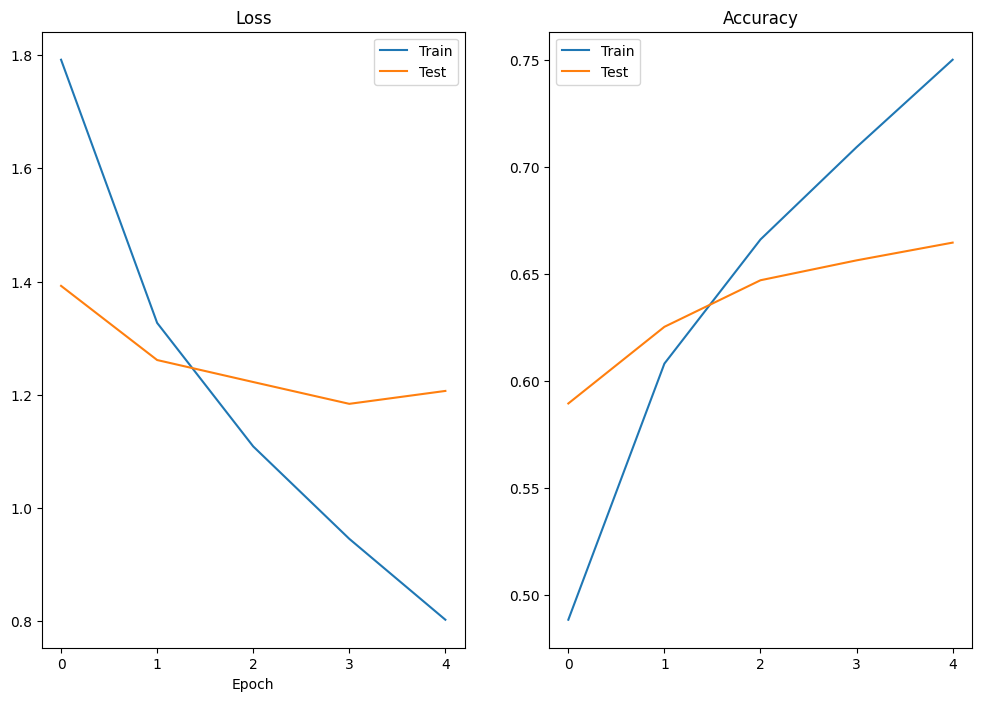

<module 'matplotlib.pyplot' from '/home/jul/anaconda3/envs/Rakuten/lib/python3.11/site-packages/matplotlib/pyplot.py'>

In [7]:
from src.utils.plot import plot_training_history
plot_training_history(model_ResNet101.model.history)

In [8]:
model_ResNet101.classification_score(X_test, y_test)

Found 16984 validated image filenames.
531/531 [==============================] - 64s 111ms/step


0.6565267480447593

In [ ]:
model_ViT.save(name='ViTb16_Ep5_lr5_10_5')
# model_efficientNet.save(name='EfficientNet_test')

In [ ]:
plot_training_history(model_ViT.history)

In [ ]:
classification_results(y_test, y_img_pred, index=class_labels['prdtypedesignation'])

              precision    recall  f1-score   support

           0       0.46      0.69      0.55       623
           1       0.68      0.72      0.70       534
           2       0.94      0.96      0.95       791
           3       0.64      0.41      0.50       153
           4       0.50      0.44      0.47       974
           5       0.43      0.27      0.33       414
           6       0.67      0.84      0.75      1009
           7       0.76      0.81      0.79       161
           8       0.58      0.46      0.51       498
           9       0.60      0.56      0.58       648
          10       0.69      0.58      0.63      1015
          11       0.84      0.84      0.84       861
          12       0.79      0.75      0.77       161
          13       0.54      0.58      0.56       999
          14       0.68      0.40      0.50       165
          15       0.81      0.79      0.80       952
          16       0.79      0.65      0.71       955
          17       0.78    

ValueError: Target is multiclass but average='binary'. Please choose another average setting, one of [None, 'micro', 'macro', 'weighted'].

## Voting classifier with Bert and ViT

In [ ]:
from sklearn.ensemble import VotingClassifier

model_txt = TFbertClassifier(base_name='camembert-base', from_trained = 'Bert_test', max_length=256, num_class=27, drop_rate=0.2, epochs=0)
model_img = ImgClassifier(base_name='b16', from_trained = 'ViT_test', img_size=(224, 224, 3), num_class=27, drop_rate=0.2, batch_size=32, learning_rate=5e-5, epochs=0)

voting_clf = VotingClassifier(estimators = [('txt_clf', model_txt), ('img_clf', model_img)], voting='soft', weights=[0.6, 0.4])
voting_clf.fit(X_train, y_train)

All model checkpoint layers were used when initializing TFCamembertModel.

All the layers of TFCamembertModel were initialized from the model checkpoint at /mnt/c/Users/Julien Fournier/Documents/GitHub/RakutenTeam/src/text/../../models/base_models/camembert-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFCamembertModel for predictions without further training.


loading weights from  Bert_test


/home/jul/anaconda3/envs/Rakuten/lib/python3.11/site-packages/vit_keras/utils.py:81: UserWarning:

Resizing position embeddings from 24, 24 to 14, 14



loading weights from  ViT_test


All model checkpoint layers were used when initializing TFCamembertModel.

All the layers of TFCamembertModel were initialized from the model checkpoint at /mnt/c/Users/Julien Fournier/Documents/GitHub/RakutenTeam/src/text/../../models/base_models/camembert-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFCamembertModel for predictions without further training.


loading weights from  Bert_test


/home/jul/anaconda3/envs/Rakuten/lib/python3.11/site-packages/vit_keras/utils.py:81: UserWarning:

Resizing position embeddings from 24, 24 to 14, 14



loading weights from  ViT_test


VotingClassifier(estimators=[('txt_clf',
                              TFbertClassifier(epochs=0,
                                               from_trained='Bert_test')),
                             ('img_clf',
                              ViTClassifier(augmentation_params={'cval': 255,
                                                                 'fill_mode': 'constant',
                                                                 'height_shift_range': 0.1,
                                                                 'horizontal_flip': True,
                                                                 'rotation_range': 20,
                                                                 'width_shift_range': 0.1},
                                            epochs=0,
                                            from_trained='ViT_test'))],
                 voting='soft', weights=[0.6, 0.4])

In [ ]:
voting_pred = voting_clf.predict(X_test)
f1_score(y_test, voting_pred, average='weighted')

2024-03-06 02:10:01.856308: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


531/531 [==============================] - 154s 275ms/step
Found 16984 validated image filenames.


2024-03-06 02:12:36.438034: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-03-06 02:12:39.342531: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


531/531 [==============================] - 140s 251ms/step


0.8585865972586947

## Stacking classifier with Bert and ViT

In [ ]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

model_txt = TFbertClassifier(base_name='camembert-base', from_trained = 'Bert_test', max_length=256, num_class=27, drop_rate=0.2, epochs=0)
model_img = ImgClassifier(base_name='b16', from_trained = 'ViT_test', img_size=(224, 224, 3), num_class=27, drop_rate=0.2, batch_size=32, learning_rate=5e-5, epochs=0)
final_clf = LogisticRegression(C=1.0, penalty='l2')

stacking_clf = StackingClassifier(estimators = [('txt_clf', model_txt), ('img_clf', model_img)], final_estimator=final_clf, cv='prefit', stack_method='predict_proba')
stacking_clf.fit(X_test, y_test)

loading from Local


All model checkpoint layers were used when initializing TFCamembertModel.

All the layers of TFCamembertModel were initialized from the model checkpoint at /mnt/c/Users/Julien Fournier/Documents/GitHub/RakutenTeam/src/text/../../models/base_models/camembert-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFCamembertModel for predictions without further training.


loading weights from  Bert_test


/home/jul/anaconda3/envs/Rakuten/lib/python3.11/site-packages/vit_keras/utils.py:81: UserWarning:

Resizing position embeddings from 24, 24 to 14, 14



loading weights from  ViT_test
531/531 [==============================] - 148s 274ms/step
Found 16984 validated image filenames.


2024-03-06 08:50:07.369828: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-03-06 08:50:10.671323: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


531/531 [==============================] - 137s 244ms/step


StackingClassifier(cv='prefit',
                   estimators=[('txt_clf',
                                TFbertClassifier(epochs=0,
                                                 from_trained='Bert_test')),
                               ('img_clf',
                                ViTClassifier(augmentation_params={'cval': 255,
                                                                   'fill_mode': 'constant',
                                                                   'height_shift_range': 0.1,
                                                                   'horizontal_flip': True,
                                                                   'rotation_range': 20,
                                                                   'width_shift_range': 0.1},
                                              epochs=0,
                                              from_trained='ViT_test'))],
                   final_estimator=LogisticRegression(),
                   stack_method='predict_proba')

In [ ]:
stacking_pred = stacking_clf.predict(X_test)
f1_score(y_test, stacking_pred, average='weighted')

531/531 [==============================] - 146s 274ms/step
Found 16984 validated image filenames.
531/531 [==============================] - 130s 245ms/step


0.868771593772429

## MultiModal transformer

In [5]:
def lrscheduler(epoch, lr):
  return lr * 0.5

callbacks = [('LearningRateScheduler', {'schedule': lrscheduler})]

model_multi = TFmultiClassifier(txt_base_name='camembert-base', img_base_name='vit_b16', 
                                 max_length=256, img_size=(224, 224, 3), augmentation_params=None,
                                 num_class=27, drop_rate=0.2, attention_numheads=8, transfo_numblocks=3,
                                 epochs=8, batch_size=32, learning_rate=5e-5, validation_data=(X_test, y_test), callbacks=callbacks)#, from_trained = {'text': 'Bert_ep8_lr5_10_5', 'image': 'ViTb16_Ep5_lr5_10_5_val10'}

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


2024-03-09 23:57:03.330537: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:17:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-09 23:57:03.330934: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:73:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-09 23:57:03.411911: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:17:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-09 23:57:03.412001: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:73:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-09 23:57:03.412049: I external/local_xla/xla/stream_executor

In [6]:
model_multi.model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 attention_mask (InputLayer  [(None, 256)]                0         []                            
 )                                                                                                
                                                                                                  
 input_ids (InputLayer)      [(None, 256)]                0         []                            
                                                                                                  
 inputs (InputLayer)         [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 txt_base_layers (TFCamembe  TFBaseModelOutputWithPooli   1106219   ['attention_mask[0][0]',

In [7]:
model_multi.fit(X_train, y_train)

Found 32 validated image filenames.
Epoch 1/8
INFO:tensorflow:Collective all_reduce tensors: 462 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1
INFO:tensorflow:Collective all_reduce IndexedSlices: 3 all_reduces, num_devices =2, group_size = 2, implementation = CommunicationImplementation.NCCL
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Collective all_reduce tensors: 462 all_reduces, num_devices = 2, g

2024-03-10 00:00:41.542857: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-03-10 00:00:41.557604: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-03-10 00:00:41.934892: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-03-10 00:00:45.241937: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-03-10 00:00:48.385902: I external/local_xla/xla/service/service.cc:168] XLA service 0x7ff5401d6bb0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-03-10 00:00:48.386021: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A5000, Compute Capability 8.6
2024-03-10 00:00:48.386043: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (1): NVIDIA RTX A5000, Compu

2123/2123 [==============================] - ETA: 0s - loss: 0.7124 - accuracy: 0.7856INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
Found 32 validated image filenames.
Found 32 validated image filenames.
Found 32 validated image filenames.
Found 32 validated image filenames.
Found 32 validated image filenames.
Found 32 validated image filenames.
Found 32 validated image filenames.
Found 32 validated image filenames.
Found 32 validated image filenames.
Found 32 validated image filenames.
Found 32 validated image filenames.
Found 32 validated image filenames.
Found 32 validated image filenames.
Found 32 validated image filenames.
Found 32 validated image filenames.
Found 32 validated image filenames.
Found 32 validated image filenames.
Found 32 validated ima

TFmultiClassifier(augmentation_params={'cval': 255, 'fill_mode': 'constant',
                                       'height_shift_range': 0.1,
                                       'horizontal_flip': True,
                                       'rotation_range': 20,
                                       'width_shift_range': 0.1},
                  callbacks=[('LearningRateScheduler',
                              {'schedule': <function lrscheduler at 0x7ff787480ea0>})],
                  epochs=8, transfo_numblocks=3,
                  validation_data=(                                                  tokens  \
0      bas de filles pour les enfants enfants collant.....
16979  /home/jul/DST/Rakuten/Data/images/image_train_...  
16980  /home/jul/DST/Rakuten/Data/images/image_train_...  
16981  /home/jul/DST/Rakuten/Data/images/image_train_...  
16982  /home/jul/DST/Rakuten/Data/images/image_train_...  
16983  /home/jul/DST/Rakuten/Data/images/image_train_...  

[16984 rows x 2 columns],
                                   0         7
1        10
2        20
3         2
4        16
         ..
16979     4
16980    16
16981    22
16982    18
16983    20
Name: prdtypeindex, Length: 16984, dtype: int64))

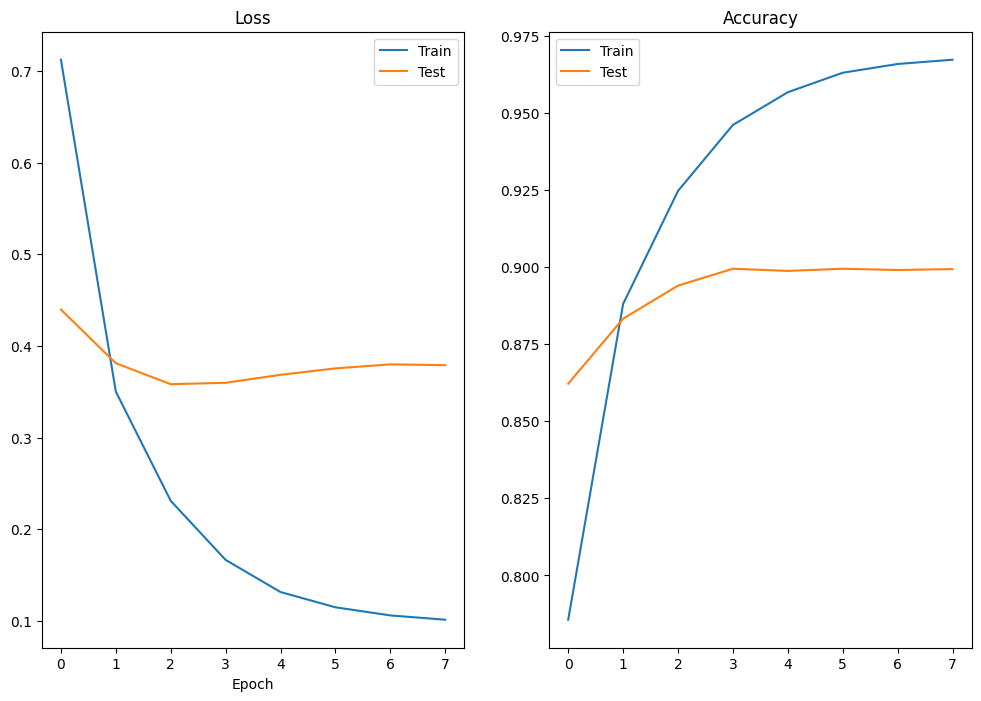

<module 'matplotlib.pyplot' from '/home/jul/anaconda3/envs/Rakuten/lib/python3.11/site-packages/matplotlib/pyplot.py'>

In [8]:
from src.utils.plot import plot_training_history

plot_training_history(model_multi.model.history)

In [9]:
model_multi.classification_score(X_test, y_test)

Found 32 validated image filenames.
Found 32 validated image filenames.
Found 32 validated image filenames.
Found 32 validated image filenames.
Found 32 validated image filenames.
Found 32 validated image filenames.
  1/531 [..............................] - ETA: 2:06:56Found 32 validated image filenames.
Found 32 validated image filenames.
Found 32 validated image filenames.
531/531 [==============================] - 214s 377ms/step


0.8984291021435897

In [10]:
model_multi.save('Fusion_TF_Bert_ViT')